In [1]:
#W1803608 VALID AL-DZHAZZAR
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

# Directory containing Excel files
data_dir = '/Users/waleedjazzar/Desktop/Year 3 Uni/Final Year Files/Datasets/MET/boulmer'

# Location 
location = 'boulmer'

#store DataFrames for each year
dfs = []

# Iterate through each year
for year in range(2016, 2021):  # Assuming data is from 2016 to 2020
    filename = f'{location}_{year}.xlsx'
    
    filepath = os.path.join(data_dir, filename)
    if os.path.exists(filepath):
        df = pd.read_excel(filepath)
        dfs.append(df)
    else:
        print(f"Warning: File '{filename}' not found for location '{location}' and year {year}. Skipping...")

# Concatenate DataFrames 
if dfs:
    combined_df = pd.concat(dfs, ignore_index=True)

    # Save processed data to a single Excel file
    combined_df = combined_df[combined_df['id_type'] == 'WIND']
    combined_df.to_excel('/Users/waleedjazzar/Desktop/Year 3 Uni/Final Year Files/Datasets/MET/boulmer/combined_boulmer_data.xlsx', index=False)
else:
    print(f"No data found for location '{location}'.")
combined_df = combined_df[combined_df['id_type'] == 'WIND']


In [2]:
#CHECK FOR NULL AND SHOW NULL
null_values = combined_df.isnull().any()
# Display the columns with null values
if null_values.any():
    print("Columns with null values:")
    print(null_values[null_values].index)
else:
    print("No null values found.")
null_indexes = combined_df[combined_df.isnull().any(axis=1)].index
print("Indexes of rows containing null values:")
print(null_indexes)


Columns with null values:
Index(['mean_wind_dir', 'mean_wind_speed', 'max_gust_dir', 'max_gust_speed',
       'max_gust_ctime', 'mean_wind_dir_q', 'mean_wind_speed_q',
       'max_gust_dir_q', 'max_gust_speed_q', 'max_gust_ctime_q',
       'mean_wind_dir_j', 'mean_wind_speed_j', 'max_gust_dir_j',
       'max_gust_speed_j', 'midas_stmp_etime'],
      dtype='object')
Indexes of rows containing null values:
Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            40794, 40795, 40796, 40797, 40798, 40799, 40800, 40801, 40802,
            40803],
           dtype='int64', length=40800)


In [3]:
#Drop unwanted columns 
columns_to_drop = ['id_type','id','ob_hour_count','met_domain_name','version_num','src_id','rec_st_ind','max_gust_ctime_q','max_gust_speed_q','max_gust_dir_q','mean_wind_speed_q','mean_wind_dir_q','mean_wind_dir_j', 'mean_wind_speed_j', 'max_gust_dir_j', 'max_gust_speed_j','meto_stmp_time','midas_stmp_etime']
combined_df = combined_df.drop(columns=columns_to_drop)
#Display the first few rows 
print(combined_df.head())

           ob_end_time  mean_wind_dir  mean_wind_speed  max_gust_dir  \
0  2016-01-01 00:00:00          240.0             11.0         240.0   
1  2016-01-01 01:00:00          250.0             12.0         250.0   
2  2016-01-01 02:00:00          250.0             10.0         240.0   
3  2016-01-01 03:00:00          240.0              9.0         250.0   
4  2016-01-01 04:00:00          190.0              6.0         220.0   

   max_gust_speed  max_gust_ctime  
0            20.0          2345.0  
1            20.0            40.0  
2            17.0            51.0  
3            18.0           213.0  
4            12.0           347.0  


In [4]:
#CHECK FOR NULL
null_values = combined_df.isnull().any()
if null_values.any():
    print("Columns with null values:")
    print(null_values[null_values].index)
else:
    print("No null values found.")
null_indexes = combined_df[combined_df.isnull().any(axis=1)].index
print("Indexes of rows containing null values:")
print(null_indexes)


Columns with null values:
Index(['mean_wind_dir', 'mean_wind_speed', 'max_gust_dir', 'max_gust_speed',
       'max_gust_ctime'],
      dtype='object')
Indexes of rows containing null values:
Int64Index([ 3363,  8130,  8131,  8132,  8133,  8134,  8135,  8136,  8137,
             8138,
            ...
            34229, 37382, 37383, 37384, 37385, 37386, 37387, 37388, 37389,
            37390],
           dtype='int64', length=781)


In [5]:

combined_df['ob_end_time'] = pd.to_datetime(combined_df['ob_end_time'])
#continuous range of dates/times covering the entire period of interest
start_date = '2016-01-01 00:00:00'
end_date = '2020-12-10 15:00:00'
continuous_range = pd.date_range(start=start_date, end=end_date, freq='H')
# Find missing dates
missing_dates = continuous_range[~continuous_range.isin(combined_df['ob_end_time'])]
if len(missing_dates) == 0:
    print("All hours are present.")
else:
    print("Some hours are missing. Missing dates:")
    print(missing_dates)
missing_dates = continuous_range[~continuous_range.isin(combined_df['ob_end_time'])]
#DataFrame from the missing dates
missing_dates_df = pd.DataFrame({'Missing Dates': missing_dates})
print(missing_dates_df)


Some hours are missing. Missing dates:
DatetimeIndex(['2016-02-16 15:00:00', '2016-02-16 16:00:00',
               '2016-02-16 17:00:00', '2016-04-06 10:00:00',
               '2016-04-06 11:00:00', '2016-04-06 12:00:00',
               '2016-04-06 13:00:00', '2016-04-06 19:00:00',
               '2016-04-06 20:00:00', '2016-04-06 21:00:00',
               ...
               '2020-02-14 01:00:00', '2020-02-14 02:00:00',
               '2020-02-14 03:00:00', '2020-02-14 04:00:00',
               '2020-02-14 05:00:00', '2020-02-14 06:00:00',
               '2020-02-14 07:00:00', '2020-02-14 08:00:00',
               '2020-02-14 09:00:00', '2020-09-21 08:00:00'],
              dtype='datetime64[ns]', length=2536, freq=None)
           Missing Dates
0    2016-02-16 15:00:00
1    2016-02-16 16:00:00
2    2016-02-16 17:00:00
3    2016-04-06 10:00:00
4    2016-04-06 11:00:00
...                  ...
2531 2020-02-14 06:00:00
2532 2020-02-14 07:00:00
2533 2020-02-14 08:00:00
2534 2020-02-14 09:

In [6]:
# Fill in the missing hours by reindexing the DataFrame with the continuous range of dates/times
combined_df_filled = combined_df.set_index('ob_end_time').reindex(continuous_range).reset_index()
print(combined_df_filled.head())

                index  mean_wind_dir  mean_wind_speed  max_gust_dir  \
0 2016-01-01 00:00:00          240.0             11.0         240.0   
1 2016-01-01 01:00:00          250.0             12.0         250.0   
2 2016-01-01 02:00:00          250.0             10.0         240.0   
3 2016-01-01 03:00:00          240.0              9.0         250.0   
4 2016-01-01 04:00:00          190.0              6.0         220.0   

   max_gust_speed  max_gust_ctime  
0            20.0          2345.0  
1            20.0            40.0  
2            17.0            51.0  
3            18.0           213.0  
4            12.0           347.0  


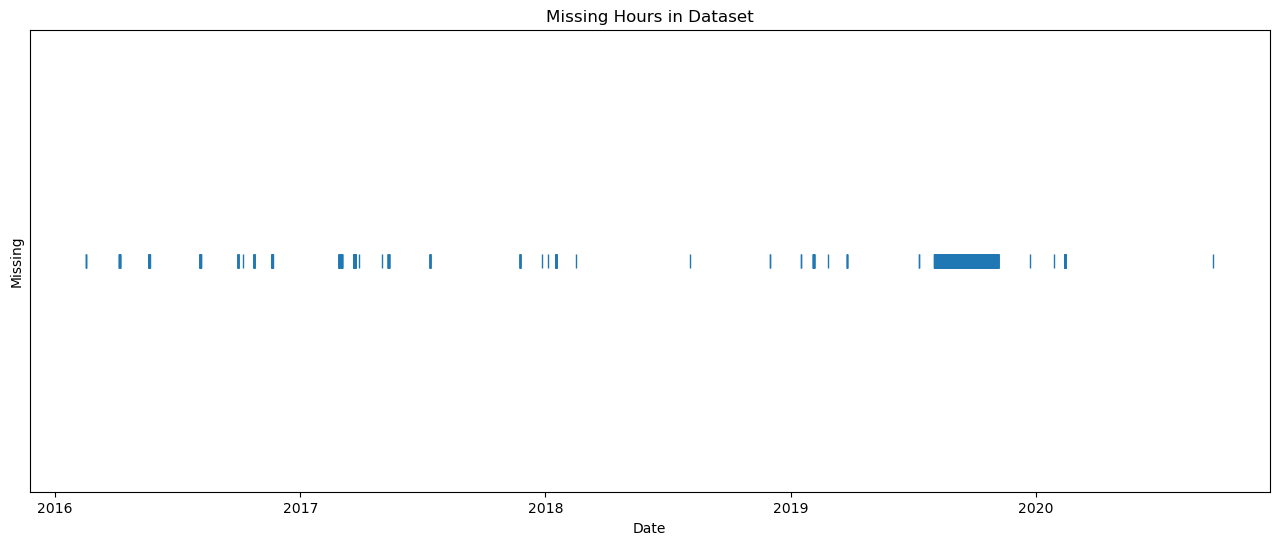

Percentage of missing data using missing hours: 5.85%
Percentage of missing values for each attribute:
index              0.000000
mean_wind_dir      7.649529
mean_wind_speed    7.654144
max_gust_dir       7.296474
max_gust_speed     7.294167
max_gust_ctime     7.294167
dtype: float64


In [7]:

# Plotting the missing dates
plt.figure(figsize=(16, 6))
plt.plot(missing_dates_df['Missing Dates'], [1] * len(missing_dates_df), '|', markersize=10)
plt.title('Missing Hours in Dataset')
plt.xlabel('Date')
plt.ylabel('Missing')
plt.yticks([])
plt.show()
# Calculate the percentage of missing data using missing dates compared to the whole dataset
percentage_missing_dates = len(missing_dates_df) / len(continuous_range) * 100
print(f"Percentage of missing data using missing hours: {percentage_missing_dates:.2f}%")
# Calculate the percentage of missing values for each attribute
missing_percentage = combined_df.isnull().mean() * 100
missing_percentage_total = combined_df_filled.isnull().mean() * 100
print("Percentage of missing values for each attribute:")
print(missing_percentage_total)


In [8]:
null_values = combined_df_filled.isnull().any()
#columns with null values,
if null_values.any():
    print("Columns with null values:")
    print(null_values[null_values].index)
else:
    print("No null values found.")
null_indexes = combined_df_filled[combined_df_filled.isnull().any(axis=1)].index
print("Indexes of rows containing null values:")
print(null_indexes)

Columns with null values:
Index(['mean_wind_dir', 'mean_wind_speed', 'max_gust_dir', 'max_gust_speed',
       'max_gust_ctime'],
      dtype='object')
Indexes of rows containing null values:
Int64Index([ 1119,  1120,  1121,  2314,  2315,  2316,  2317,  2323,  2324,
             2325,
            ...
            39913, 39914, 39915, 39916, 39917, 39918, 39919, 39920, 39921,
            41408],
           dtype='int64', length=3317)


In [9]:
#new DataFrame without missing values
Wind_Clean = combined_df_filled.dropna()
# Check the shape
print("Size of Wind_Clean:", Wind_Clean.shape)
print(Wind_Clean.head())


Size of Wind_Clean: (40019, 6)
                index  mean_wind_dir  mean_wind_speed  max_gust_dir  \
0 2016-01-01 00:00:00          240.0             11.0         240.0   
1 2016-01-01 01:00:00          250.0             12.0         250.0   
2 2016-01-01 02:00:00          250.0             10.0         240.0   
3 2016-01-01 03:00:00          240.0              9.0         250.0   
4 2016-01-01 04:00:00          190.0              6.0         220.0   

   max_gust_speed  max_gust_ctime  
0            20.0          2345.0  
1            20.0            40.0  
2            17.0            51.0  
3            18.0           213.0  
4            12.0           347.0  


/var/folders/6r/2nrcfqbx669gydmwvq5cyd5h0000gn/T/ipykernel_60642/41885308.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Wind_Clean['year'] = Wind_Clean['index'].dt.year


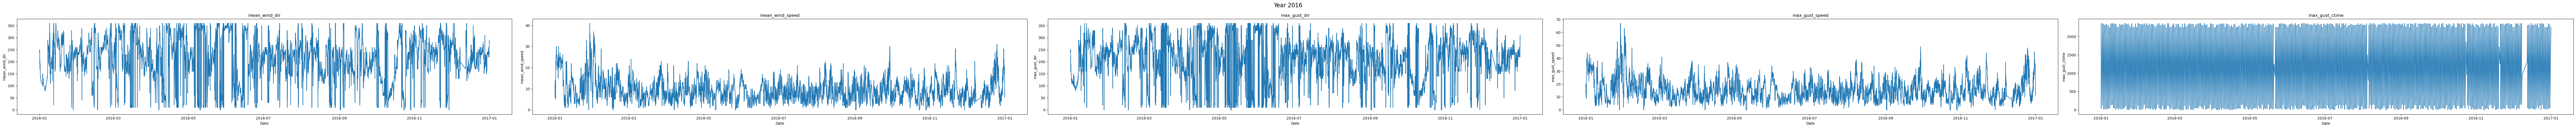

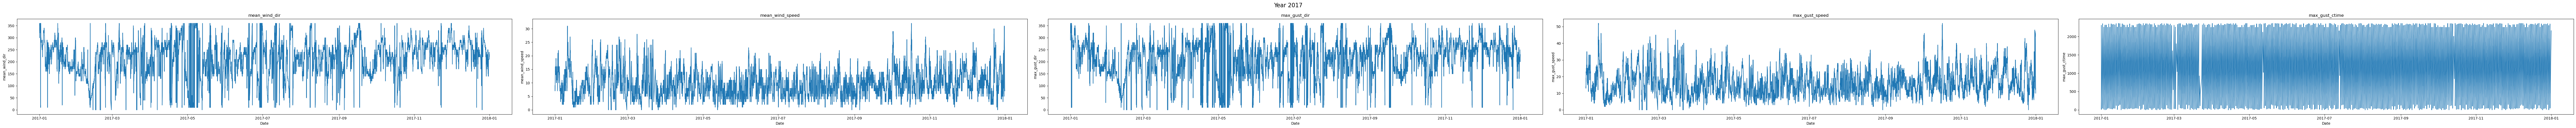

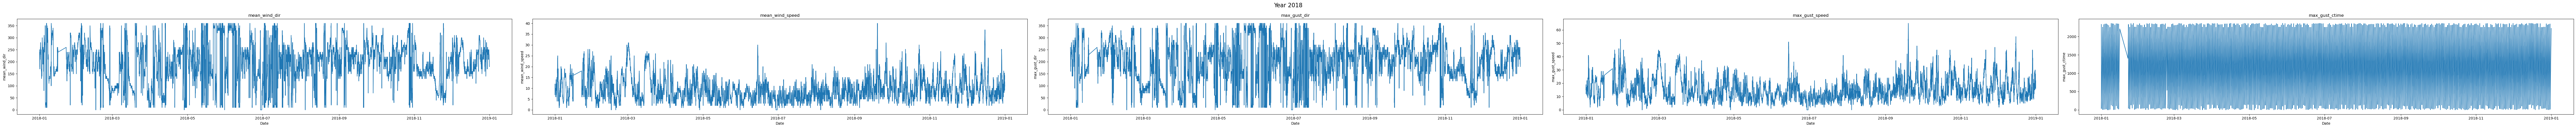

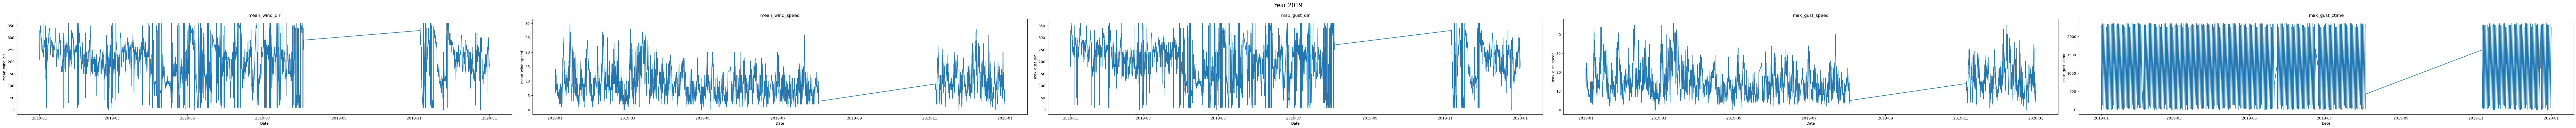

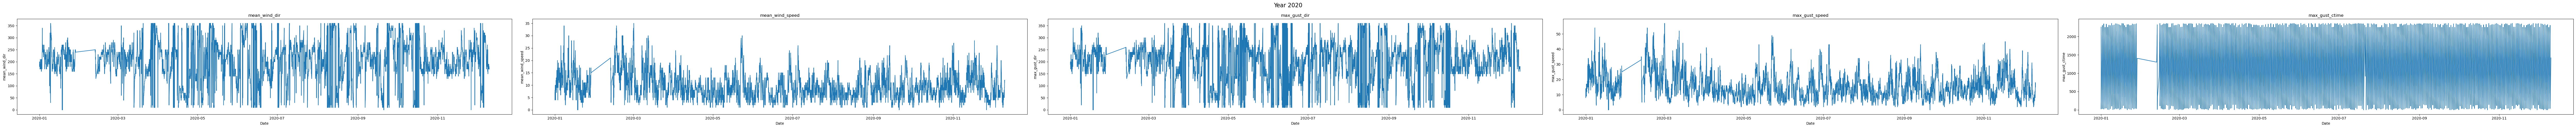

In [10]:
#extract year 
Wind_Clean['year'] = Wind_Clean['index'].dt.year

# Iterate over each year and plot line charts for each variable
for year in sorted(Wind_Clean['year'].unique()):
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(100, 5))
    fig.suptitle(f'Year {year}', fontsize=16)
    df_year = Wind_Clean[Wind_Clean['year'] == year]
    # Plot line charts for each variable
    for i, col in enumerate(['mean_wind_dir', 'mean_wind_speed', 'max_gust_dir', 'max_gust_speed', 'max_gust_ctime']):
        ax = axes[i]
        ax.plot(df_year['index'], df_year[col])
        ax.set_title(col)
        ax.set_xlabel('Date')
        ax.set_ylabel(col)
    plt.tight_layout()
    plt.show()


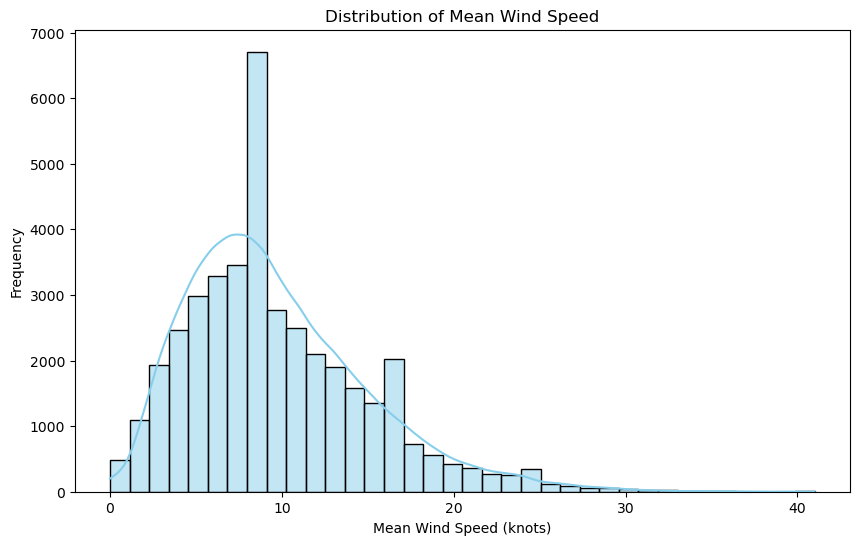

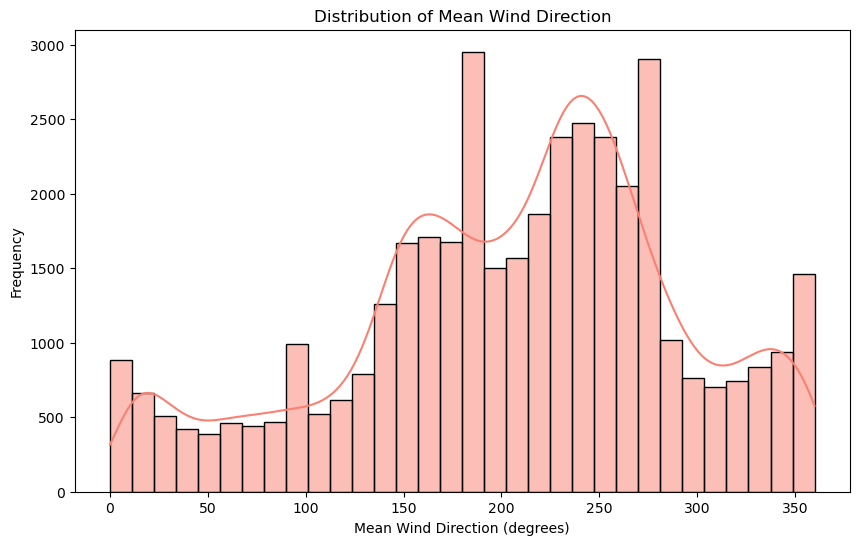

In [11]:
# Plot histogram of mean_wind_speed
plt.figure(figsize=(10, 6))
sns.histplot(Wind_Clean['mean_wind_speed'], bins=36, kde=True, color='skyblue')
plt.title('Distribution of Mean Wind Speed')
plt.xlabel('Mean Wind Speed (knots)')
plt.ylabel('Frequency')
plt.show()
# Plot histogram of mean_wind_dir
plt.figure(figsize=(10, 6))
sns.histplot(Wind_Clean['mean_wind_dir'], bins=32, kde=True, color='salmon')
plt.title('Distribution of Mean Wind Direction')
plt.xlabel('Mean Wind Direction (degrees)')
plt.ylabel('Frequency')
plt.show()

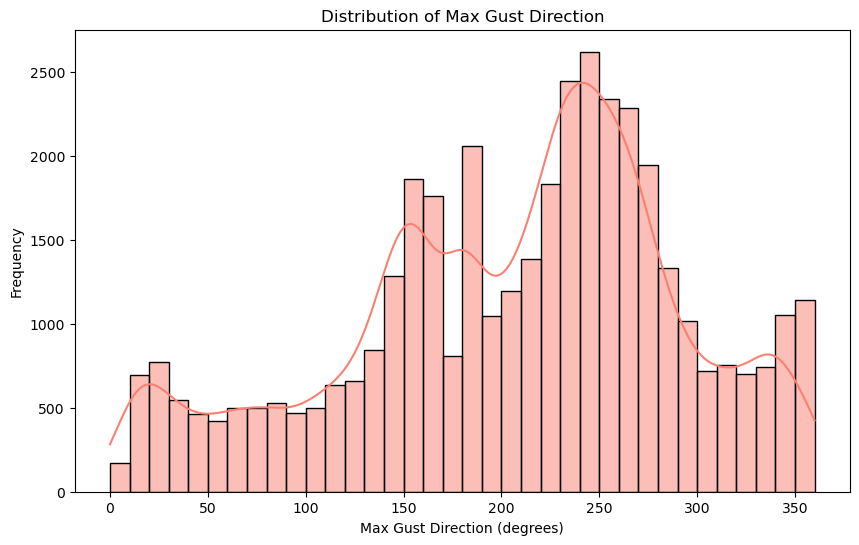

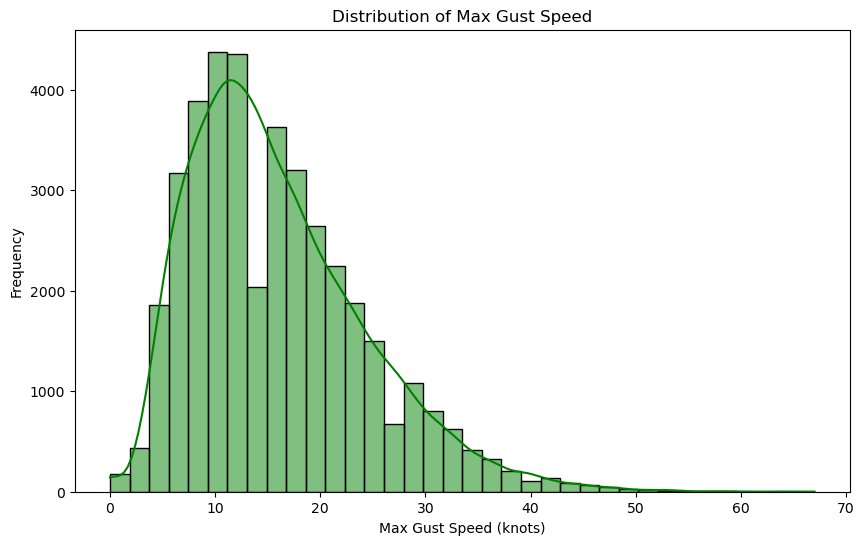

In [12]:
# Plot histogram of max_gust_dir
plt.figure(figsize=(10, 6))
sns.histplot(Wind_Clean['max_gust_dir'], bins=36, kde=True, color='salmon')
plt.title('Distribution of Max Gust Direction')
plt.xlabel('Max Gust Direction (degrees)')
plt.ylabel('Frequency')
plt.show()
# Plot histogram of max_gust_speed
plt.figure(figsize=(10, 6))
sns.histplot(Wind_Clean['max_gust_speed'], bins=36, kde=True, color='green')
plt.title('Distribution of Max Gust Speed')
plt.xlabel('Max Gust Speed (knots)')
plt.ylabel('Frequency')
plt.show()

In [13]:
# Interpolate for each hub height
z_ref = 23  # Reference height where wind speed is recorded (m)
z_hub = [87, 120, 125]  # Hub heights of the wind turbines (m)
z_0 = 0.03  # Roughness length of the terrain (m)
for height in z_hub:
    # Calculate the wind speed at the hub height using the logarithmic wind profile equation
    wind_speed = Wind_Clean['mean_wind_speed'] * (np.log(height / z_0) / np.log(z_ref / z_0))
    Wind_Clean[f'wind_speed_{height}m'] = wind_speed
print(Wind_Clean.head())


                index  mean_wind_dir  mean_wind_speed  max_gust_dir  \
0 2016-01-01 00:00:00          240.0             11.0         240.0   
1 2016-01-01 01:00:00          250.0             12.0         250.0   
2 2016-01-01 02:00:00          250.0             10.0         240.0   
3 2016-01-01 03:00:00          240.0              9.0         250.0   
4 2016-01-01 04:00:00          190.0              6.0         220.0   

   max_gust_speed  max_gust_ctime  year  wind_speed_87m  wind_speed_120m  \
0            20.0          2345.0  2016       13.203318        13.735897   
1            20.0            40.0  2016       14.403620        14.984615   
2            17.0            51.0  2016       12.003016        12.487179   
3            18.0           213.0  2016       10.802715        11.238461   
4            12.0           347.0  2016        7.201810         7.492308   

   wind_speed_125m  
0        13.803503  
1        15.058367  
2        12.548639  
3        11.293775  
4         7

/var/folders/6r/2nrcfqbx669gydmwvq5cyd5h0000gn/T/ipykernel_60642/811617846.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Wind_Clean[f'wind_speed_{height}m'] = wind_speed
/var/folders/6r/2nrcfqbx669gydmwvq5cyd5h0000gn/T/ipykernel_60642/811617846.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Wind_Clean[f'wind_speed_{height}m'] = wind_speed
/var/folders/6r/2nrcfqbx669gydmwvq5cyd5h0000gn/T/ipykernel_60642/811617846.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [14]:

#File path for Turbine Power Curve
file_path = "/Users/waleedjazzar/Desktop/Year 3 Uni/Final Year Files/Datasets/PowerCurves.xlsx"
# Excel into a pandas DataFrame
power_curves_df = pd.read_excel(file_path)
print(power_curves_df.head())


   Wind_speed  SG 8.0-167 DD  V164/9500  WT10000dd/190 SeaTitan
0         0.0              0          0                       0
1         0.5              0          0                       0
2         1.0              0          0                       0
3         1.5              0          0                       0
4         2.0              0          0                       0


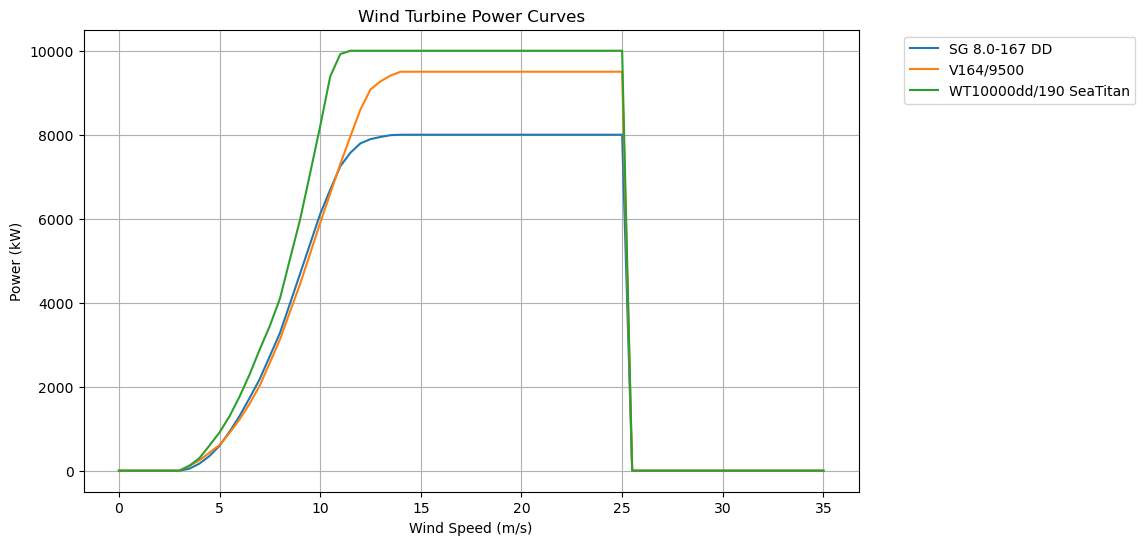

In [15]:
# Extract wind speed values
wind_speeds = power_curves_df['Wind_speed'].astype(float)
# Extract power values for each turbine (excluding 'Wind_speed' column)
power_values = power_curves_df.drop(columns=['Wind_speed']).astype(float)
#power curve for each turbine
plt.figure(figsize=(10, 6))
for column in power_values.columns:
    plt.plot(wind_speeds, power_values[column], label=column)
plt.title('Wind Turbine Power Curves')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power (kW)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  
plt.grid(True)
plt.show()


In [16]:

# turbine models and hieghts 
turbine_models = ['SG 8.0-167 DD', 'V164/9500', 'WT10000dd/190 SeaTitan']
heights = [87, 120, 125]
#calculate hourly kW generation for each turbine model and height
def calculate_hourly_kW(turbine_model, height, wind_speed):
    # Interpolate the power curve
    power_output = np.interp(wind_speed, power_curves_df['Wind_speed'], power_curves_df[turbine_model])
    # 1 hour for time interval
    hourly_kW = power_output * 1  
    return hourly_kW
# Apply the function to each row in Wind_Clean DataFrame for each turbine model and height
for turbine_model, height in zip(turbine_models, heights):
    Wind_Clean[f'hourly_kW_generation_{turbine_model.replace("/", "_").replace(" ", "_")}_{height}m'] = \
        Wind_Clean[f'wind_speed_{height}m'].apply(lambda x: calculate_hourly_kW(turbine_model, height, x))
print(Wind_Clean)


/var/folders/6r/2nrcfqbx669gydmwvq5cyd5h0000gn/T/ipykernel_60642/1828865445.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Wind_Clean[f'hourly_kW_generation_{turbine_model.replace("/", "_").replace(" ", "_")}_{height}m'] = \
/var/folders/6r/2nrcfqbx669gydmwvq5cyd5h0000gn/T/ipykernel_60642/1828865445.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Wind_Clean[f'hourly_kW_generation_{turbine_model.replace("/", "_").replace(" ", "_")}_{height}m'] = \


                    index  mean_wind_dir  mean_wind_speed  max_gust_dir  \
0     2016-01-01 00:00:00          240.0             11.0         240.0   
1     2016-01-01 01:00:00          250.0             12.0         250.0   
2     2016-01-01 02:00:00          250.0             10.0         240.0   
3     2016-01-01 03:00:00          240.0              9.0         250.0   
4     2016-01-01 04:00:00          190.0              6.0         220.0   
...                   ...            ...              ...           ...   
43331 2020-12-10 11:00:00          180.0              9.0         180.0   
43332 2020-12-10 12:00:00          170.0             12.0         170.0   
43333 2020-12-10 13:00:00          170.0             11.0         160.0   
43334 2020-12-10 14:00:00          170.0             12.0         180.0   
43335 2020-12-10 15:00:00          170.0             12.0         180.0   

       max_gust_speed  max_gust_ctime  year  wind_speed_87m  wind_speed_120m  \
0                20

/var/folders/6r/2nrcfqbx669gydmwvq5cyd5h0000gn/T/ipykernel_60642/1828865445.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Wind_Clean[f'hourly_kW_generation_{turbine_model.replace("/", "_").replace(" ", "_")}_{height}m'] = \


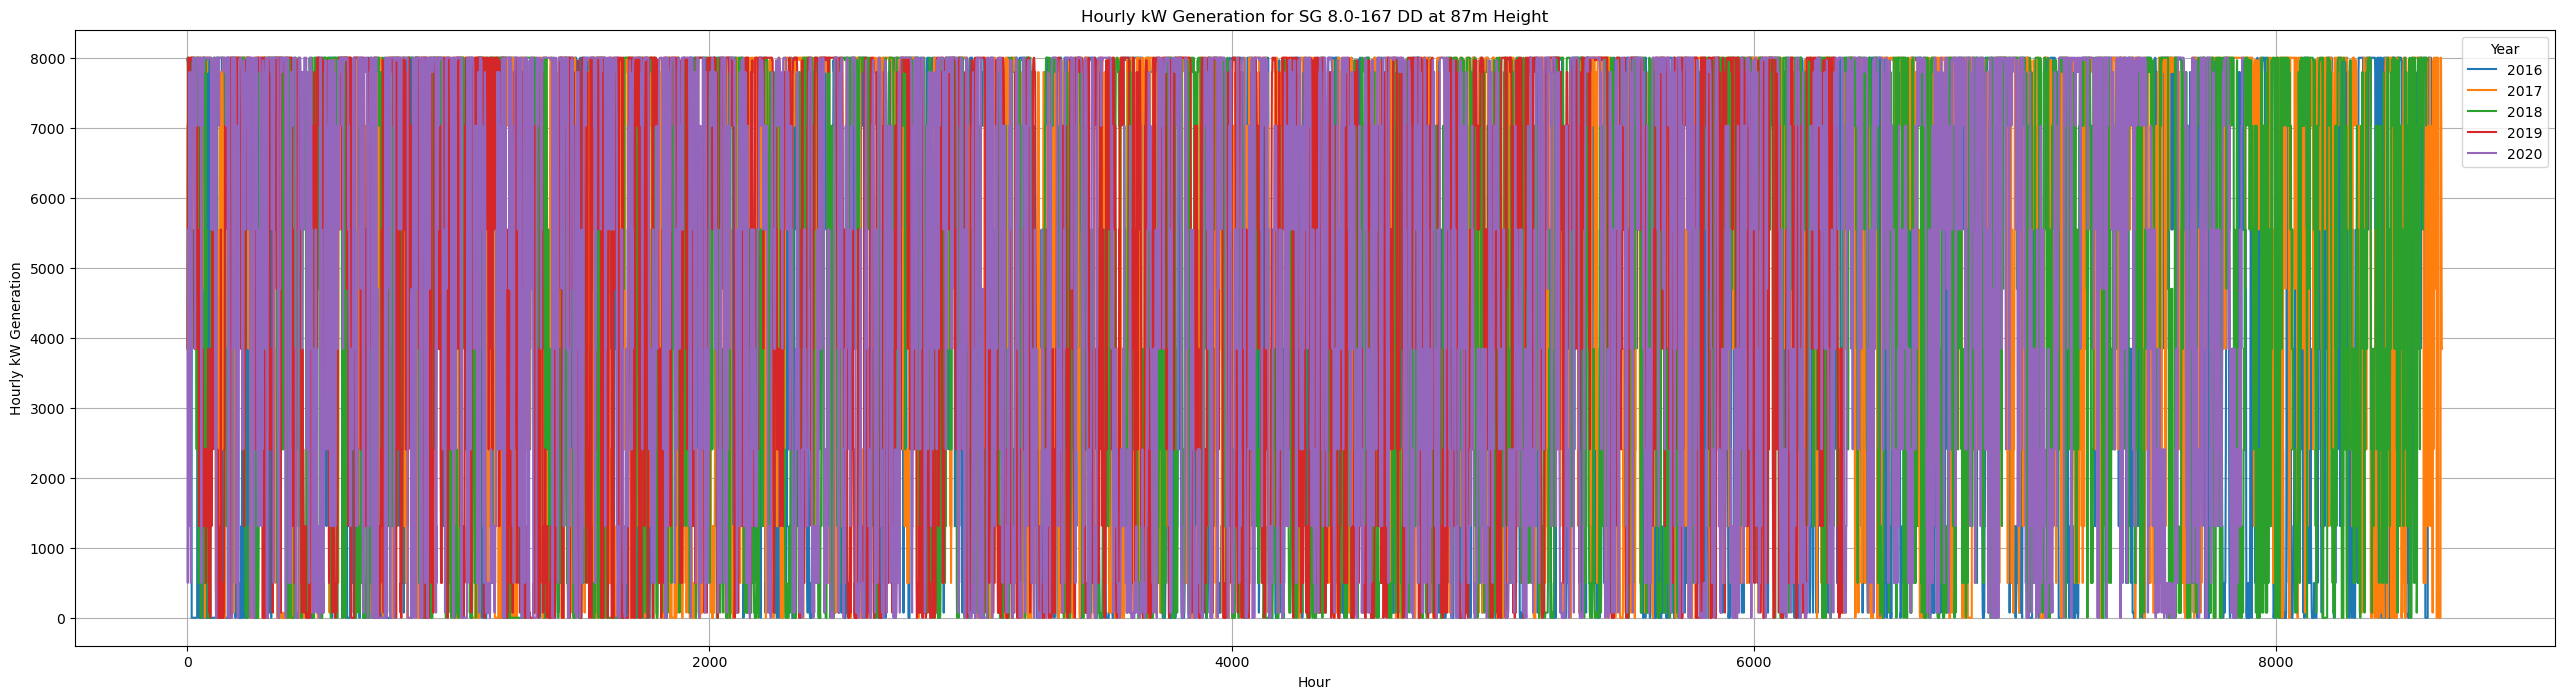

In [17]:

# Define the turbine model
turbine_model = 'SG 8.0-167 DD'
height = 87
filtered_data = Wind_Clean[['year', f'hourly_kW_generation_{turbine_model.replace("/", "_").replace(" ", "_")}_{height}m']]
grouped_data = filtered_data.groupby('year')

# Plot each year's data separately
plt.figure(figsize=(32, 8))
for year, group in grouped_data:
    plt.plot(range(1, len(group) + 1), group[f'hourly_kW_generation_{turbine_model.replace("/", "_").replace(" ", "_")}_{height}m'], label=year)

plt.title(f'Hourly kW Generation for {turbine_model} at {height}m Height')
plt.xlabel('Hour')
plt.ylabel('Hourly kW Generation')
plt.legend(title='Year')
plt.grid(True)
plt.show()


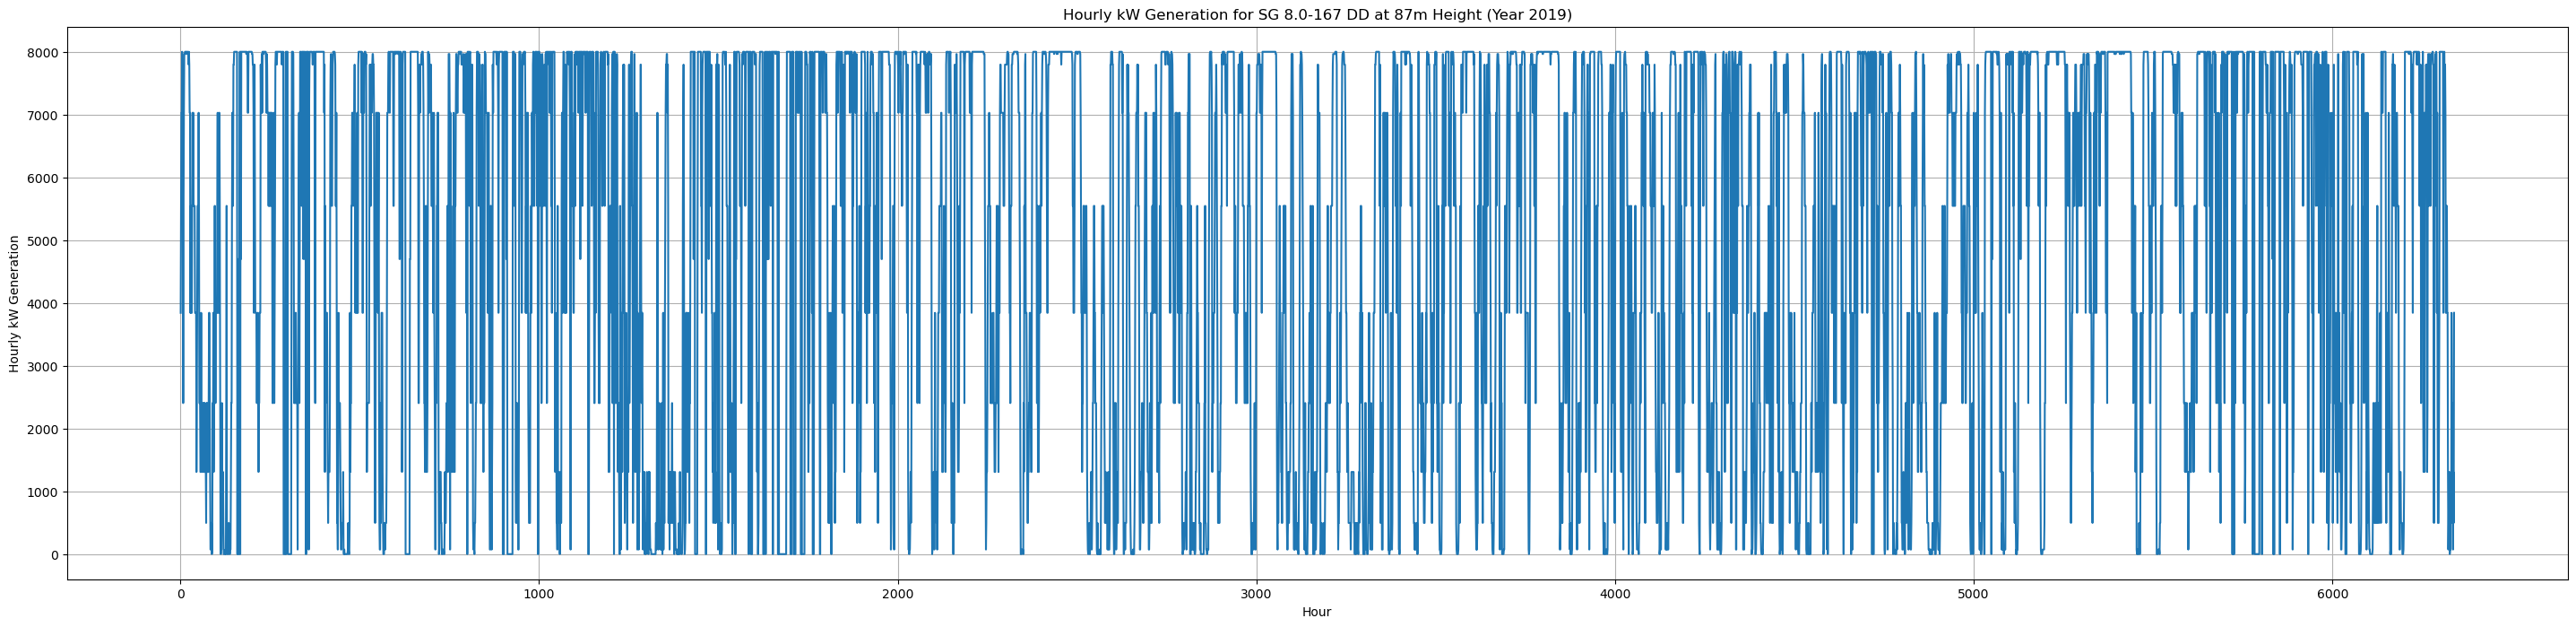

In [18]:
import matplotlib.pyplot as plt

# Define the turbine model 
turbine_model = 'SG 8.0-167 DD'
height = 87
filtered_data_2019 = Wind_Clean[Wind_Clean['year'] == 2019][f'hourly_kW_generation_{turbine_model.replace("/", "_").replace(" ", "_")}_{height}m']
# Plot the data for the year 2019
plt.figure(figsize=(36, 8))
plt.plot(range(1, len(filtered_data_2019) + 1), filtered_data_2019)
plt.title(f'Hourly kW Generation for {turbine_model} at {height}m Height (Year 2019)')
plt.xlabel('Hour')
plt.ylabel('Hourly kW Generation')
plt.grid(True)
plt.show()


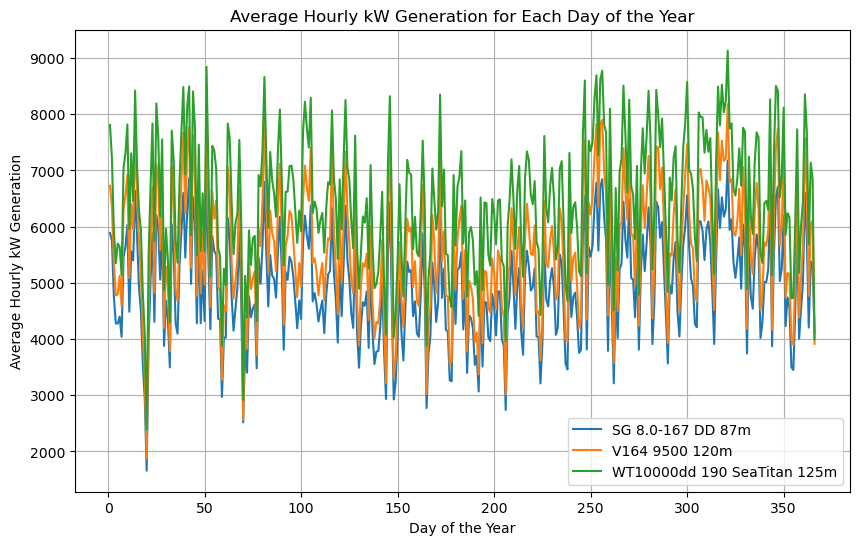

In [19]:

# Calculate average hourly kW generation for each turbine for each day of the year
avg_daily_SG_8_0_167_DD_87m = Wind_Clean.groupby(Wind_Clean['index'].dt.dayofyear)['hourly_kW_generation_SG_8.0-167_DD_87m'].mean()
avg_daily_V164_9500_120m = Wind_Clean.groupby(Wind_Clean['index'].dt.dayofyear)['hourly_kW_generation_V164_9500_120m'].mean()
avg_daily_WT10000dd_190_SeaTitan_125m = Wind_Clean.groupby(Wind_Clean['index'].dt.dayofyear)['hourly_kW_generation_WT10000dd_190_SeaTitan_125m'].mean()
# Plot the average hourly kW generation for each turbine for each day of the year
plt.figure(figsize=(10, 6))
plt.plot(avg_daily_SG_8_0_167_DD_87m.index, avg_daily_SG_8_0_167_DD_87m, label='SG 8.0-167 DD 87m')
plt.plot(avg_daily_V164_9500_120m.index, avg_daily_V164_9500_120m, label='V164 9500 120m')
plt.plot(avg_daily_WT10000dd_190_SeaTitan_125m.index, avg_daily_WT10000dd_190_SeaTitan_125m, label='WT10000dd 190 SeaTitan 125m')
plt.xlabel('Day of the Year')
plt.ylabel('Average Hourly kW Generation')
plt.title('Average Hourly kW Generation for Each Day of the Year')
plt.legend()
plt.grid(True)
plt.show()


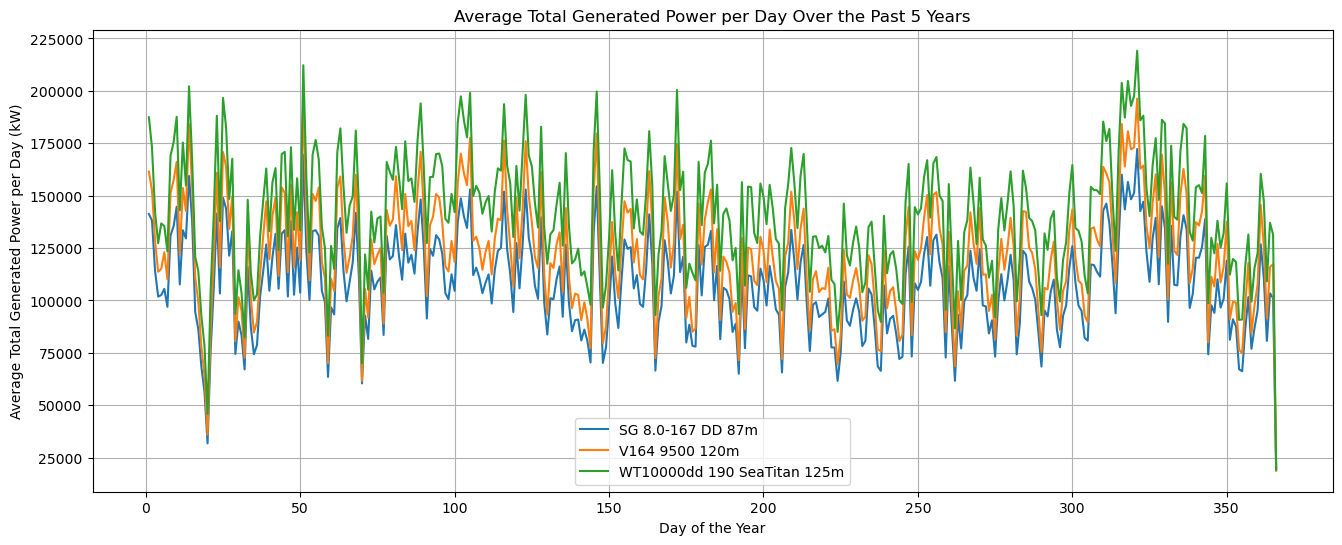

In [20]:
# Calculate total generated power per day on average over the past 5 years for each turbine
avg_total_daily_SG_8_0_167_DD_87m = Wind_Clean.groupby(Wind_Clean['index'].dt.dayofyear)['hourly_kW_generation_SG_8.0-167_DD_87m'].sum() / 5
avg_total_daily_V164_9500_120m = Wind_Clean.groupby(Wind_Clean['index'].dt.dayofyear)['hourly_kW_generation_V164_9500_120m'].sum() / 5
avg_total_daily_WT10000dd_190_SeaTitan_125m = Wind_Clean.groupby(Wind_Clean['index'].dt.dayofyear)['hourly_kW_generation_WT10000dd_190_SeaTitan_125m'].sum() / 5
# Plot the average total generated power per day over the past 5 years for each turbine
plt.figure(figsize=(16, 6))
plt.plot(avg_total_daily_SG_8_0_167_DD_87m.index, avg_total_daily_SG_8_0_167_DD_87m, label='SG 8.0-167 DD 87m')
plt.plot(avg_total_daily_V164_9500_120m.index, avg_total_daily_V164_9500_120m, label='V164 9500 120m')
plt.plot(avg_total_daily_WT10000dd_190_SeaTitan_125m.index, avg_total_daily_WT10000dd_190_SeaTitan_125m, label='WT10000dd 190 SeaTitan 125m')
plt.xlabel('Day of the Year')
plt.ylabel('Average Total Generated Power per Day (kW)')
plt.title('Average Total Generated Power per Day Over the Past 5 Years')
plt.legend()
plt.grid(True)
plt.show()


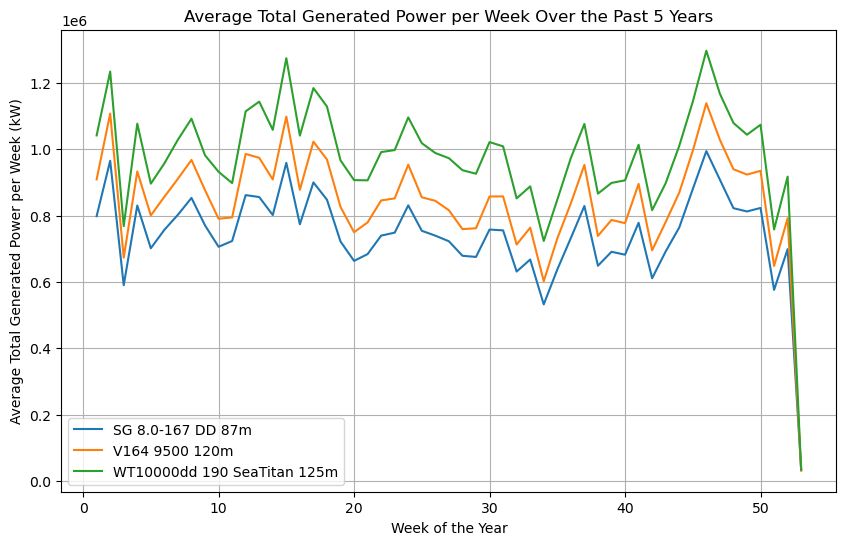

In [21]:
# Calculate total generated power per week on average over the past 5 years for each turbine
avg_total_weekly_SG_8_0_167_DD_87m = Wind_Clean.groupby(Wind_Clean['index'].dt.isocalendar().week)['hourly_kW_generation_SG_8.0-167_DD_87m'].sum() / 5
avg_total_weekly_V164_9500_120m = Wind_Clean.groupby(Wind_Clean['index'].dt.isocalendar().week)['hourly_kW_generation_V164_9500_120m'].sum() / 5
avg_total_weekly_WT10000dd_190_SeaTitan_125m = Wind_Clean.groupby(Wind_Clean['index'].dt.isocalendar().week)['hourly_kW_generation_WT10000dd_190_SeaTitan_125m'].sum() / 5
# Plot the average total generated power per week over the past 5 years for each turbine
plt.figure(figsize=(10, 6))
plt.plot(avg_total_weekly_SG_8_0_167_DD_87m.index, avg_total_weekly_SG_8_0_167_DD_87m, label='SG 8.0-167 DD 87m')
plt.plot(avg_total_weekly_V164_9500_120m.index, avg_total_weekly_V164_9500_120m, label='V164 9500 120m')
plt.plot(avg_total_weekly_WT10000dd_190_SeaTitan_125m.index, avg_total_weekly_WT10000dd_190_SeaTitan_125m, label='WT10000dd 190 SeaTitan 125m')
plt.xlabel('Week of the Year')
plt.ylabel('Average Total Generated Power per Week (kW)')
plt.title('Average Total Generated Power per Week Over the Past 5 Years')
plt.legend()
plt.grid(True)
plt.show()


In [22]:
# Select relevant columns for modeling
X = Wind_Clean[['mean_wind_speed']]
y_87m = Wind_Clean['hourly_kW_generation_SG_8.0-167_DD_87m']
y_120m = Wind_Clean['hourly_kW_generation_V164_9500_120m']
y_125m = Wind_Clean['hourly_kW_generation_WT10000dd_190_SeaTitan_125m']
# Split the data into training and testing sets
X_train_87m, X_test_87m, y_train_87m, y_test_87m = train_test_split(X, y_87m, test_size=0.2, random_state=42)
X_train_120m, X_test_120m, y_train_120m, y_test_120m = train_test_split(X, y_120m, test_size=0.2, random_state=42)
X_train_125m, X_test_125m, y_train_125m, y_test_125m = train_test_split(X, y_125m, test_size=0.2, random_state=42)
#linear regression models
model_87m = LinearRegression()
model_120m = LinearRegression()
model_125m = LinearRegression()
# Train models
model_87m.fit(X_train_87m, y_train_87m)
model_120m.fit(X_train_120m, y_train_120m)
model_125m.fit(X_train_125m, y_train_125m)
# Make predictions
y_pred_87m = model_87m.predict(X_test_87m)
y_pred_120m = model_120m.predict(X_test_120m)
y_pred_125m = model_125m.predict(X_test_125m)
print("Model Evaluation for 87m Height:")
print("Mean Squared Error:", mean_squared_error(y_test_87m, y_pred_87m))
print("R-squared:", r2_score(y_test_87m, y_pred_87m))
print("Model Evaluation for 120m Height:")
print("Mean Squared Error:", mean_squared_error(y_test_120m, y_pred_120m))
print("R-squared:", r2_score(y_test_120m, y_pred_120m))
print("Model Evaluation for 125m Height:")
print("Mean Squared Error:", mean_squared_error(y_test_125m, y_pred_125m))
print("R-squared:", r2_score(y_test_125m, y_pred_125m))


Model Evaluation for 87m Height:
Mean Squared Error: 7263413.556374585
R-squared: 0.2580076026663318
Model Evaluation for 120m Height:
Mean Squared Error: 10487411.589362927
R-squared: 0.24658234253610334
Model Evaluation for 125m Height:
Mean Squared Error: 12793290.357943188
R-squared: 0.18106964946758064


In [23]:
# Select relevant columns for modeling
X = Wind_Clean[['mean_wind_speed']]
y_87m = Wind_Clean['hourly_kW_generation_SG_8.0-167_DD_87m']
y_120m = Wind_Clean['hourly_kW_generation_V164_9500_120m']
y_125m = Wind_Clean['hourly_kW_generation_WT10000dd_190_SeaTitan_125m']
# Split the data into training and testing sets
X_train_87m, X_test_87m, y_train_87m, y_test_87m = train_test_split(X, y_87m, test_size=0.2, random_state=42)
X_train_120m, X_test_120m, y_train_120m, y_test_120m = train_test_split(X, y_120m, test_size=0.2, random_state=42)
X_train_125m, X_test_125m, y_train_125m, y_test_125m = train_test_split(X, y_125m, test_size=0.2, random_state=42)
# Initialize MLP regressor models with increased max_iter
model_87m = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', random_state=42, max_iter=1000)
model_120m = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', random_state=42, max_iter=1000)
model_125m = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', random_state=42, max_iter=1000)
# Train models
model_87m.fit(X_train_87m, y_train_87m)
model_120m.fit(X_train_120m, y_train_120m)
model_125m.fit(X_train_125m, y_train_125m)
# Make predictions
y_pred_87m = model_87m.predict(X_test_87m)
y_pred_120m = model_120m.predict(X_test_120m)
y_pred_125m = model_125m.predict(X_test_125m)
print("Model Evaluation for 87m Height:")
print("Mean Squared Error:", mean_squared_error(y_test_87m, y_pred_87m))
print("R-squared:", r2_score(y_test_87m, y_pred_87m))
print("Model Evaluation for 120m Height:")
print("Mean Squared Error:", mean_squared_error(y_test_120m, y_pred_120m))
print("R-squared:", r2_score(y_test_120m, y_pred_120m))
print("Model Evaluation for 125m Height:")
print("Mean Squared Error:", mean_squared_error(y_test_125m, y_pred_125m))
print("R-squared:", r2_score(y_test_125m, y_pred_125m))


Model Evaluation for 87m Height:
Mean Squared Error: 14659.49510855286
R-squared: 0.9985024625357108
Model Evaluation for 120m Height:
Mean Squared Error: 13699.805772536107
R-squared: 0.9990158033290766
Model Evaluation for 125m Height:
Mean Squared Error: 31667.99836634844
R-squared: 0.9979728526221785


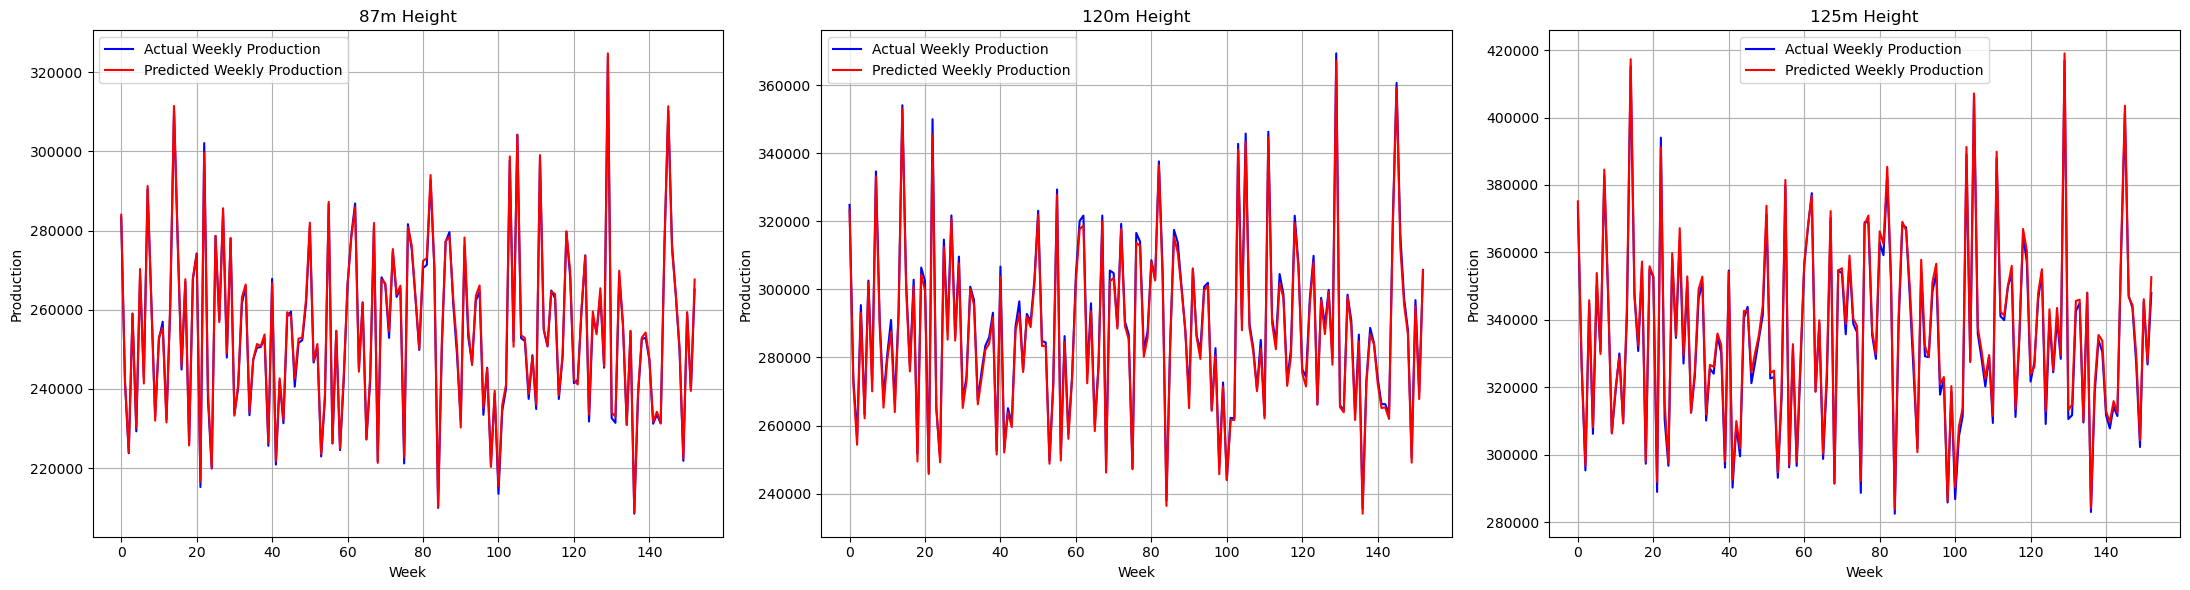

In [24]:
# Select relevant columns for modeling
X = Wind_Clean[['mean_wind_speed']]
y_87m = Wind_Clean['hourly_kW_generation_SG_8.0-167_DD_87m']
y_120m = Wind_Clean['hourly_kW_generation_V164_9500_120m']
y_125m = Wind_Clean['hourly_kW_generation_WT10000dd_190_SeaTitan_125m']
# Split the data into training and testing sets
X_train_87m, X_test_87m, y_train_87m, y_test_87m = train_test_split(X, y_87m, test_size=0.2, random_state=42)
X_train_120m, X_test_120m, y_train_120m, y_test_120m = train_test_split(X, y_120m, test_size=0.2, random_state=42)
X_train_125m, X_test_125m, y_train_125m, y_test_125m = train_test_split(X, y_125m, test_size=0.2, random_state=42)
# Aggregate actual and predicted values on a weekly basis
def aggregate_weekly(values):
    num_weeks = len(values) // 52 
    weekly_values = []
    for i in range(num_weeks):
        weekly_values.append(np.sum(values[i*52:(i+1)*52]))
    return np.array(weekly_values)
# Aggregate actual and predicted values for each height
y_test_weekly_87m = aggregate_weekly(y_test_87m)
y_pred_weekly_87m = aggregate_weekly(y_pred_87m)
y_test_weekly_120m = aggregate_weekly(y_test_120m)
y_pred_weekly_120m = aggregate_weekly(y_pred_120m)
y_test_weekly_125m = aggregate_weekly(y_test_125m)
y_pred_weekly_125m = aggregate_weekly(y_pred_125m)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(22, 6))
# Plot 87m 
axes[0].plot(y_test_weekly_87m, label='Actual Weekly Production', color='blue')
axes[0].plot(y_pred_weekly_87m, label='Predicted Weekly Production', color='red')
axes[0].set_title('87m Height')
axes[0].set_xlabel('Week')
axes[0].set_ylabel('Production')
axes[0].legend()
axes[0].grid(True)
# Plot 120m 
axes[1].plot(y_test_weekly_120m, label='Actual Weekly Production', color='blue')
axes[1].plot(y_pred_weekly_120m, label='Predicted Weekly Production', color='red')
axes[1].set_title('120m Height')
axes[1].set_xlabel('Week')
axes[1].set_ylabel('Production')
axes[1].legend()
axes[1].grid(True)
# Plot 125m 
axes[2].plot(y_test_weekly_125m, label='Actual Weekly Production', color='blue')
axes[2].plot(y_pred_weekly_125m, label='Predicted Weekly Production', color='red')
axes[2].set_title('125m Height')
axes[2].set_xlabel('Week')
axes[2].set_ylabel('Production')
axes[2].legend()
axes[2].grid(True)
plt.tight_layout()
plt.show()


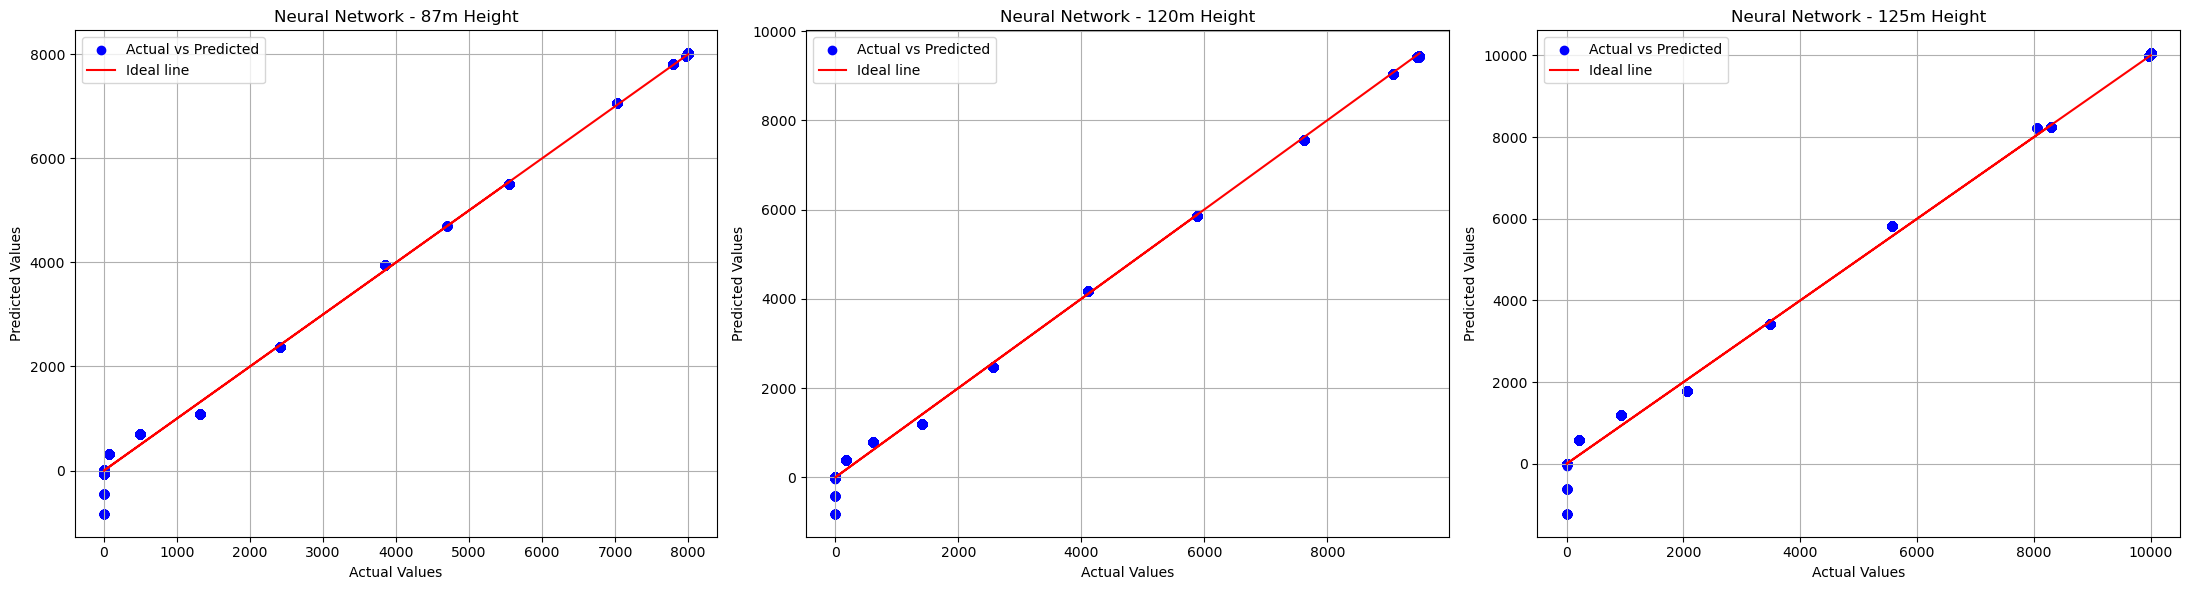

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(22, 6))
# Visualize predictions for 87m Height
axes[0].scatter(y_test_87m, y_pred_87m, color='blue', label='Actual vs Predicted')
axes[0].plot(y_test_87m, y_test_87m, color='red', label='Ideal line')
axes[0].set_title('Neural Network - 87m Height')
axes[0].set_xlabel('Actual Values')
axes[0].set_ylabel('Predicted Values')
axes[0].legend()
axes[0].grid(True)
# Visualize predictions for 120m Height
axes[1].scatter(y_test_120m, y_pred_120m, color='blue', label='Actual vs Predicted')
axes[1].plot(y_test_120m, y_test_120m, color='red', label='Ideal line')
axes[1].set_title('Neural Network - 120m Height')
axes[1].set_xlabel('Actual Values')
axes[1].set_ylabel('Predicted Values')
axes[1].legend()
axes[1].grid(True)
# Visualize predictions for 125m Height
axes[2].scatter(y_test_125m, y_pred_125m, color='blue', label='Actual vs Predicted')
axes[2].plot(y_test_125m, y_test_125m, color='red', label='Ideal line')
axes[2].set_title('Neural Network - 125m Height')
axes[2].set_xlabel('Actual Values')
axes[2].set_ylabel('Predicted Values')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()


In [26]:
# Define ARIMA parameters
order = (5, 1, 0)  
# Fit ARIMA models for each height
arima_model_87m = ARIMA(y_train_87m.values, order=order)
arima_fit_87m = arima_model_87m.fit()
arima_model_120m = ARIMA(y_train_120m.values, order=order)
arima_fit_120m = arima_model_120m.fit()
arima_model_125m = ARIMA(y_train_125m.values, order=order)
arima_fit_125m = arima_model_125m.fit()
# predictions
y_pred_87m = arima_fit_87m.forecast(steps=len(X_test_87m))
y_pred_120m = arima_fit_120m.forecast(steps=len(X_test_120m))
y_pred_125m = arima_fit_125m.forecast(steps=len(X_test_125m))
# Evaluate models
mse_87m = mean_squared_error(y_test_87m, y_pred_87m)
r2_87m = r2_score(y_test_87m, y_pred_87m)
mse_120m = mean_squared_error(y_test_120m, y_pred_120m)
r2_120m = r2_score(y_test_120m, y_pred_120m)
mse_125m = mean_squared_error(y_test_125m, y_pred_125m)
r2_125m = r2_score(y_test_125m, y_pred_125m)
print("ARIMA Model Evaluation for 87m Height:")
print("Mean Squared Error:", mse_87m)
print("R-squared:", r2_87m)
print("ARIMA Model Evaluation for 120m Height:")
print("Mean Squared Error:", mse_120m)
print("R-squared:", r2_120m)
print("ARIMA Model Evaluation for 125m Height:")
print("Mean Squared Error:", mse_125m)
print("R-squared:", r2_125m)


ARIMA Model Evaluation for 87m Height:
Mean Squared Error: 15705274.907953197
R-squared: -0.6043688672400198
ARIMA Model Evaluation for 120m Height:
Mean Squared Error: 23452365.38558225
R-squared: -0.6848224216463796
ARIMA Model Evaluation for 125m Height:
Mean Squared Error: 23414867.104033444
R-squared: -0.4988439086955081


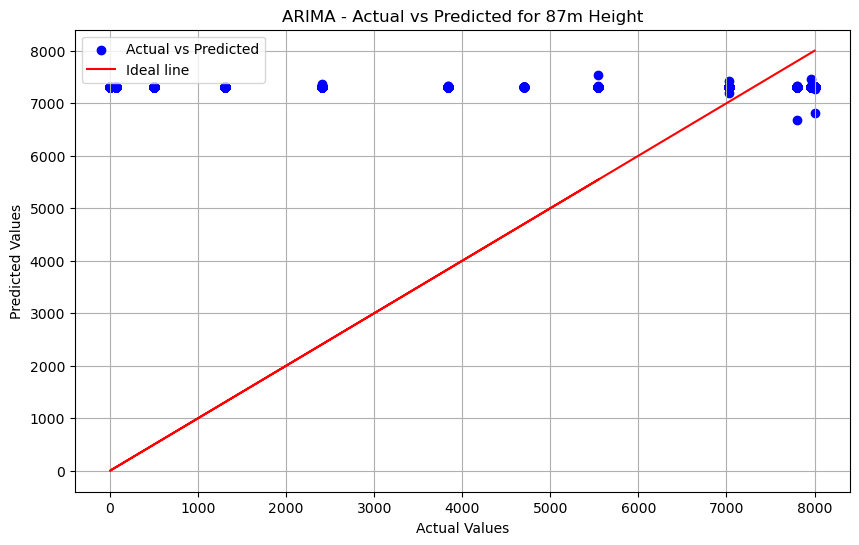

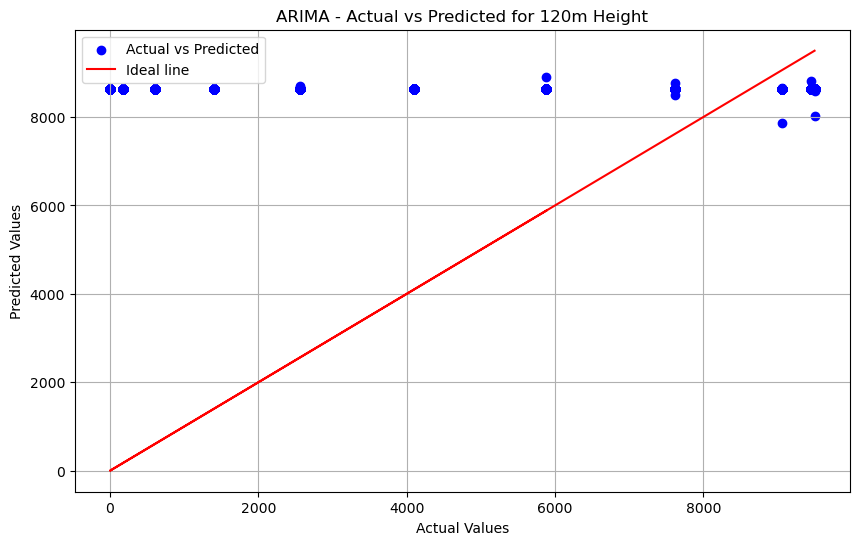

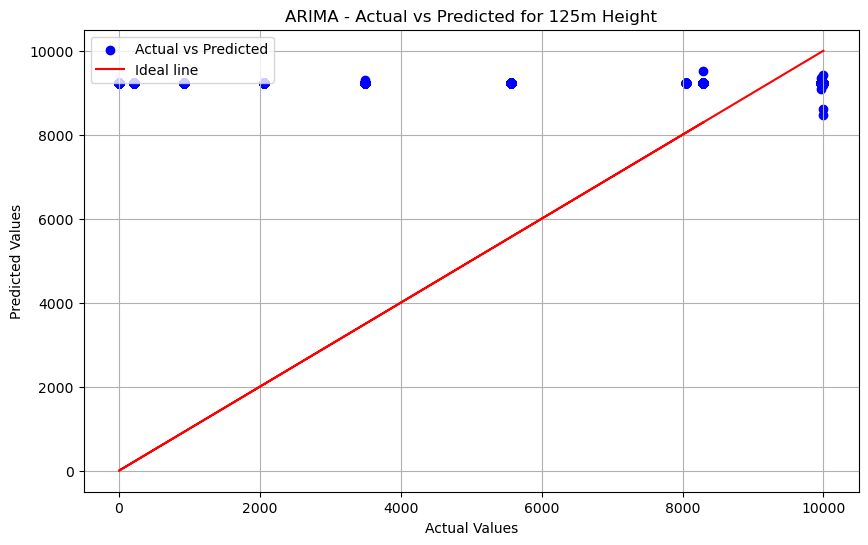

In [27]:
# Visualize predictions for 87m Height
plt.figure(figsize=(10, 6))
plt.scatter(y_test_87m, y_pred_87m, color='blue', label='Actual vs Predicted')
plt.plot(y_test_87m, y_test_87m, color='red', label='Ideal line')
plt.title('ARIMA - Actual vs Predicted for 87m Height')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()
# Visualize predictions for 120m Height
plt.figure(figsize=(10, 6))
plt.scatter(y_test_120m, y_pred_120m, color='blue', label='Actual vs Predicted')
plt.plot(y_test_120m, y_test_120m, color='red', label='Ideal line')
plt.title('ARIMA - Actual vs Predicted for 120m Height')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()
# Visualize predictions for 125m Height
plt.figure(figsize=(10, 6))
plt.scatter(y_test_125m, y_pred_125m, color='blue', label='Actual vs Predicted')
plt.plot(y_test_125m, y_test_125m, color='red', label='Ideal line')
plt.title('ARIMA - Actual vs Predicted for 125m Height')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()


In [28]:
from sklearn.ensemble import RandomForestRegressor
# Random Forest models
rf_model_87m = RandomForestRegressor(random_state=42)
rf_model_120m = RandomForestRegressor(random_state=42)
rf_model_125m = RandomForestRegressor(random_state=42)
# Train  models
rf_model_87m.fit(X_train_87m, y_train_87m)
rf_model_120m.fit(X_train_120m, y_train_120m)
rf_model_125m.fit(X_train_125m, y_train_125m)
# predictions
rf_y_pred_87m = rf_model_87m.predict(X_test_87m)
rf_y_pred_120m = rf_model_120m.predict(X_test_120m)
rf_y_pred_125m = rf_model_125m.predict(X_test_125m)
print("Random Forest Model Evaluation for 87m Height:")
print("Mean Squared Error:", mean_squared_error(y_test_87m, rf_y_pred_87m))
print("R-squared:", r2_score(y_test_87m, rf_y_pred_87m))
print("Random Forest Model Evaluation for 120m Height:")
print("Mean Squared Error:", mean_squared_error(y_test_120m, rf_y_pred_120m))
print("R-squared:", r2_score(y_test_120m, rf_y_pred_120m))
print("Random Forest Model Evaluation for 125m Height:")
print("Mean Squared Error:", mean_squared_error(y_test_125m, rf_y_pred_125m))
print("R-squared:", r2_score(y_test_125m, rf_y_pred_125m))


Random Forest Model Evaluation for 87m Height:
Mean Squared Error: 1.6215426184069622e-21
R-squared: 1.0
Random Forest Model Evaluation for 120m Height:
Mean Squared Error: 3.0985818588719834e-21
R-squared: 1.0
Random Forest Model Evaluation for 125m Height:
Mean Squared Error: 5.528260940382658e-21
R-squared: 1.0


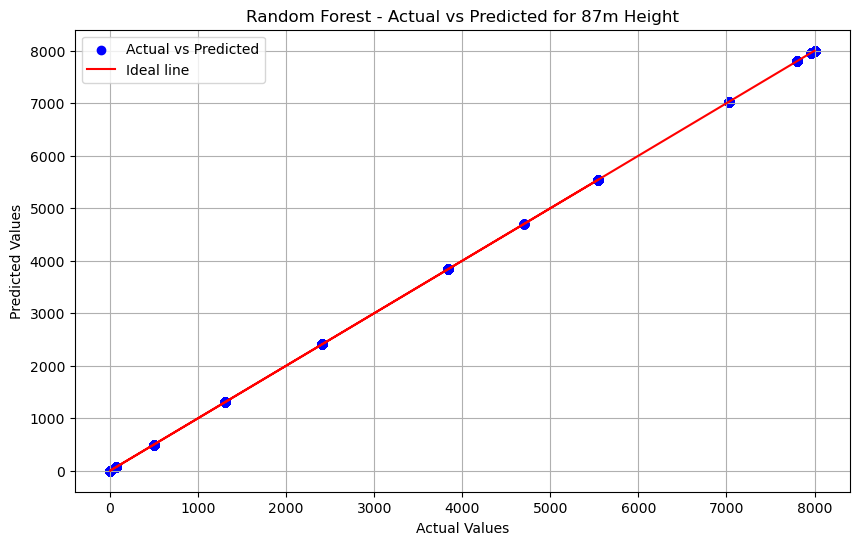

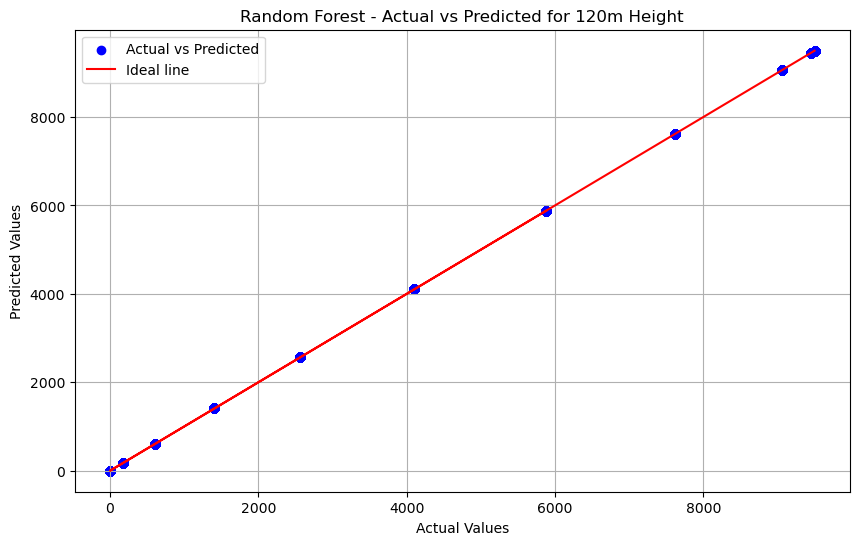

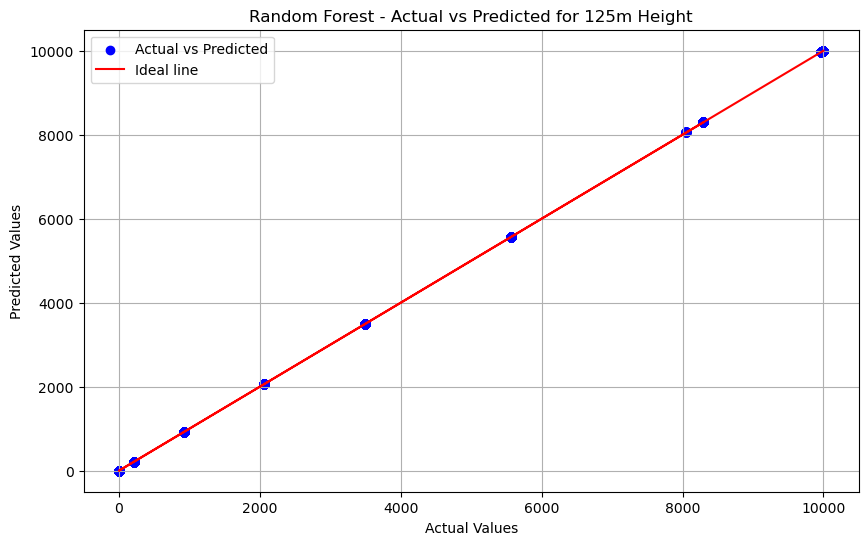

In [29]:
# Visualize predictions for 87m Height
plt.figure(figsize=(10, 6))
plt.scatter(y_test_87m, rf_y_pred_87m, color='blue', label='Actual vs Predicted')
plt.plot(y_test_87m, y_test_87m, color='red', label='Ideal line')
plt.title('Random Forest - Actual vs Predicted for 87m Height')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()
# Visualize predictions for 120m Height
plt.figure(figsize=(10, 6))
plt.scatter(y_test_120m, rf_y_pred_120m, color='blue', label='Actual vs Predicted')
plt.plot(y_test_120m, y_test_120m, color='red', label='Ideal line')
plt.title('Random Forest - Actual vs Predicted for 120m Height')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()
# Visualize predictions for 125m Height
plt.figure(figsize=(10, 6))
plt.scatter(y_test_125m, rf_y_pred_125m, color='blue', label='Actual vs Predicted')
plt.plot(y_test_125m, y_test_125m, color='red', label='Ideal line')
plt.title('Random Forest - Actual vs Predicted for 125m Height')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()


In [30]:
# Define the number of folds for cross-validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)
# Define the hyperparameters grid
param_grid = {
    'max_depth': [5, 10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
# Random Forest regressor
rf_reg = RandomForestRegressor(random_state=42)
# GridSearchCV
grid_search = GridSearchCV(estimator=rf_reg, param_grid=param_grid, cv=kf, scoring='neg_mean_squared_error')
# Perform GridSearchCV for 87m height
grid_search.fit(X_train_87m, y_train_87m)
best_params_87m = grid_search.best_params_
# Perform GridSearchCV for 120m height
grid_search.fit(X_train_120m, y_train_120m)   
best_params_120m = grid_search.best_params_
# Perform GridSearchCV for 125m height
grid_search.fit(X_train_125m, y_train_125m)
best_params_125m = grid_search.best_params_
print("Best Hyperparameters for 87m Height:", best_params_87m)
print("Best Hyperparameters for 120m Height:", best_params_120m)
print("Best Hyperparameters for 125m Height:", best_params_125m)


Best Hyperparameters for 87m Height: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Hyperparameters for 120m Height: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Hyperparameters for 125m Height: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [31]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
# Random Forest models with best hyperparameters
rf_model_87m_best = RandomForestRegressor(max_depth=10, min_samples_leaf=1, min_samples_split=2, random_state=42)
rf_model_120m_best = RandomForestRegressor(max_depth=5, min_samples_leaf=1, min_samples_split=2, random_state=42)
rf_model_125m_best = RandomForestRegressor(max_depth=10, min_samples_leaf=1, min_samples_split=2, random_state=42)
# Train  models
rf_model_87m_best.fit(X_train_87m, y_train_87m)
rf_model_120m_best.fit(X_train_120m, y_train_120m)
rf_model_125m_best.fit(X_train_125m, y_train_125m)
rf_y_pred_87m_best = rf_model_87m_best.predict(X_test_87m)
rf_y_pred_120m_best = rf_model_120m_best.predict(X_test_120m)
rf_y_pred_125m_best = rf_model_125m_best.predict(X_test_125m)
print("Random Forest Model Evaluation for 87m Height (Best Hyperparameters):")
print("Mean Squared Error:", mean_squared_error(y_test_87m, rf_y_pred_87m_best))
print("R-squared:", r2_score(y_test_87m, rf_y_pred_87m_best))
print("\nRandom Forest Model Evaluation for 120m Height (Best Hyperparameters):")
print("Mean Squared Error:", mean_squared_error(y_test_120m, rf_y_pred_120m_best))
print("R-squared:", r2_score(y_test_120m, rf_y_pred_120m_best))
print("\nRandom Forest Model Evaluation for 125m Height (Best Hyperparameters):")
print("Mean Squared Error:", mean_squared_error(y_test_125m, rf_y_pred_125m_best))
print("R-squared:", r2_score(y_test_125m, rf_y_pred_125m_best))


Random Forest Model Evaluation for 87m Height (Best Hyperparameters):
Mean Squared Error: 1.6215426184069622e-21
R-squared: 1.0

Random Forest Model Evaluation for 120m Height (Best Hyperparameters):
Mean Squared Error: 3.0985818588719834e-21
R-squared: 1.0

Random Forest Model Evaluation for 125m Height (Best Hyperparameters):
Mean Squared Error: 5.528260940382658e-21
R-squared: 1.0


In [32]:
# Support Vector Machine models
svm_model_87m = SVR()
svm_model_120m = SVR()
svm_model_125m = SVR()
# Train models
svm_model_87m.fit(X_train_87m, y_train_87m)
svm_model_120m.fit(X_train_120m, y_train_120m)
svm_model_125m.fit(X_train_125m, y_train_125m)
# Make predictions
svm_y_pred_87m = svm_model_87m.predict(X_test_87m)
svm_y_pred_120m = svm_model_120m.predict(X_test_120m)
svm_y_pred_125m = svm_model_125m.predict(X_test_125m)
print("Support Vector Machine Model Evaluation for 87m Height:")
print("Mean Squared Error:", mean_squared_error(y_test_87m, svm_y_pred_87m))
print("R-squared:", r2_score(y_test_87m, svm_y_pred_87m))
print("Support Vector Machine Model Evaluation for 120m Height:")
print("Mean Squared Error:", mean_squared_error(y_test_120m, svm_y_pred_120m))
print("R-squared:", r2_score(y_test_120m, svm_y_pred_120m))
print("Support Vector Machine Model Evaluation for 125m Height:")
print("Mean Squared Error:", mean_squared_error(y_test_125m, svm_y_pred_125m))
print("R-squared:", r2_score(y_test_125m, svm_y_pred_125m))

Support Vector Machine Model Evaluation for 87m Height:
Mean Squared Error: 815225.8931328738
R-squared: 0.91672078009612
Support Vector Machine Model Evaluation for 120m Height:
Mean Squared Error: 1541940.6886140925
R-squared: 0.8892266855682291
Support Vector Machine Model Evaluation for 125m Height:
Mean Squared Error: 1970739.4907753204
R-squared: 0.8738480612232281


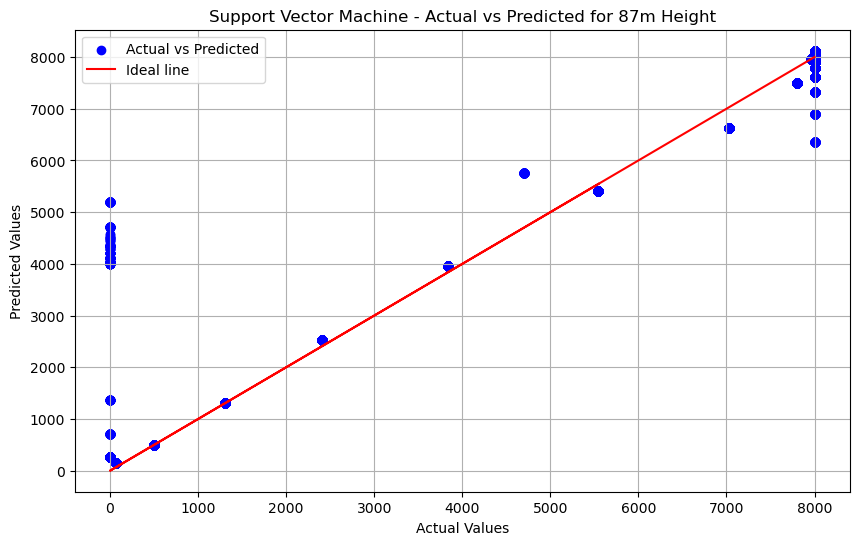

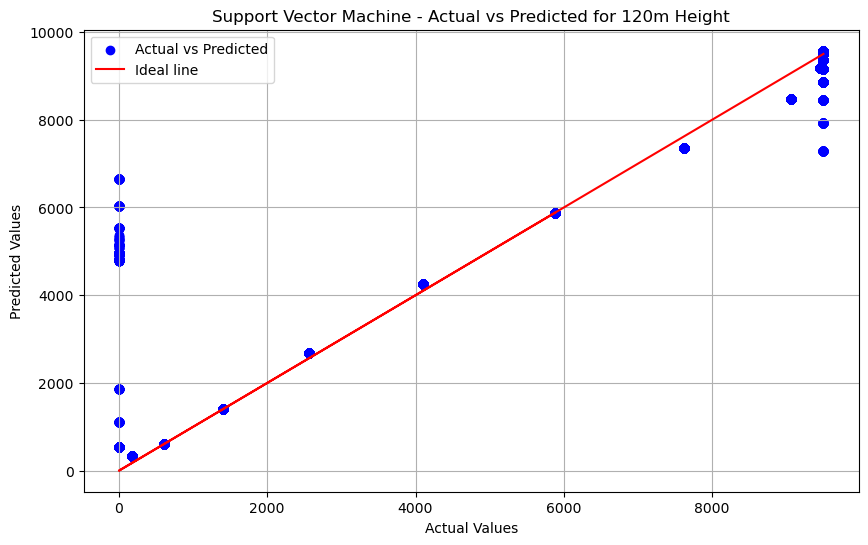

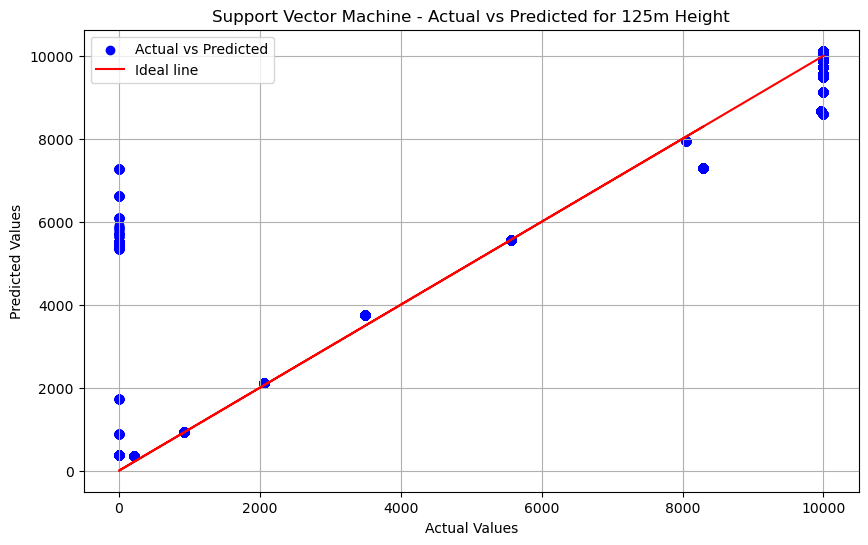

In [33]:
# Visualize predictions for 87m Height
plt.figure(figsize=(10, 6))
plt.scatter(y_test_87m, svm_y_pred_87m, color='blue', label='Actual vs Predicted')
plt.plot(y_test_87m, y_test_87m, color='red', label='Ideal line')
plt.title('Support Vector Machine - Actual vs Predicted for 87m Height')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()
# Visualize predictions for 120m Height
plt.figure(figsize=(10, 6))
plt.scatter(y_test_120m, svm_y_pred_120m, color='blue', label='Actual vs Predicted')
plt.plot(y_test_120m, y_test_120m, color='red', label='Ideal line')
plt.title('Support Vector Machine - Actual vs Predicted for 120m Height')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()
# Visualize predictions for 125m Height
plt.figure(figsize=(10, 6))
plt.scatter(y_test_125m, svm_y_pred_125m, color='blue', label='Actual vs Predicted')
plt.plot(y_test_125m, y_test_125m, color='red', label='Ideal line')
plt.title('Support Vector Machine - Actual vs Predicted for 125m Height')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()


In [34]:
# Ordinary Least Squares model
model_87m = sm.OLS(y_train_87m, X_train_87m)
model_120m = sm.OLS(y_train_120m, X_train_120m)
model_125m = sm.OLS(y_train_125m, X_train_125m)
# Train the model
trained_model_87m = model_87m.fit()
trained_model_120m = model_120m.fit()
trained_model_125m = model_125m.fit()
# Make predictions
pred_87m = trained_model_87m.predict(X_test_87m)
pred_120m = trained_model_120m.predict(X_test_120m)
pred_125m = trained_model_125m.predict(X_test_125m)
#evaluation metrics
mse_val_87m = mean_squared_error(y_test_87m, pred_87m)
mse_val_120m = mean_squared_error(y_test_120m, pred_120m)
mse_val_125m = mean_squared_error(y_test_125m, pred_125m)
r2_87m = r2_score(y_test_87m, pred_87m)
r2_120m = r2_score(y_test_120m, pred_120m)
r2_125m = r2_score(y_test_125m, pred_125m)
adjr2_87m = 1 - (1 - r2_87m) * (X_test_87m.shape[0] - 1) / (X_test_87m.shape[0] - X_test_87m.shape[1] - 1)
adjr2_120m = 1 - (1 - r2_120m) * (X_test_120m.shape[0] - 1) / (X_test_120m.shape[0] - X_test_120m.shape[1] - 1)
adjr2_125m = 1 - (1 - r2_125m) * (X_test_125m.shape[0] - 1) / (X_test_125m.shape[0] - X_test_125m.shape[1] - 1)
print("Model Evaluation for 87m Height:")
print("Mean Squared Error:", mse_val_87m)
print("R-squared:", r2_87m)
print("Adjusted R-squared:", adjr2_87m)
print(trained_model_87m.summary())
print("\nModel Evaluation for 120m Height:")
print("Mean Squared Error:", mse_val_120m)
print("R-squared:", r2_120m)
print("Adjusted R-squared:", adjr2_120m)
print(trained_model_120m.summary())
print("\nModel Evaluation for 125m Height:")
print("Mean Squared Error:", mse_val_125m)
print("R-squared:", r2_125m)
print("Adjusted R-squared:", adjr2_125m)
print(trained_model_125m.summary())

Model Evaluation for 87m Height:
Mean Squared Error: 8190985.7943212
R-squared: 0.1632516668804458
Adjusted R-squared: 0.16314709948065587
                                           OLS Regression Results                                          
Dep. Variable:     hourly_kW_generation_SG_8.0-167_DD_87m   R-squared (uncentered):                   0.774
Model:                                                OLS   Adj. R-squared (uncentered):              0.774
Method:                                     Least Squares   F-statistic:                          1.097e+05
Date:                                    Tue, 20 Feb 2024   Prob (F-statistic):                        0.00
Time:                                            06:41:51   Log-Likelihood:                     -2.9924e+05
No. Observations:                                   32015   AIC:                                  5.985e+05
Df Residuals:                                       32014   BIC:                                  5.985e+

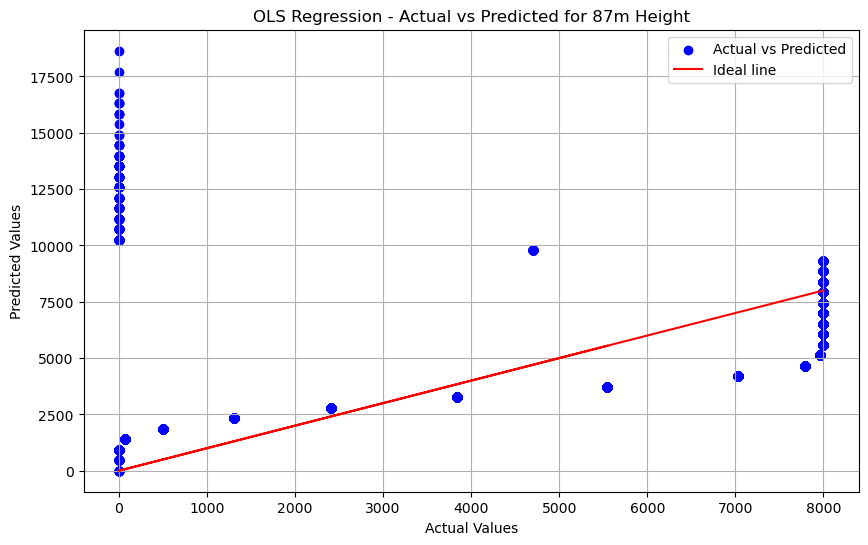

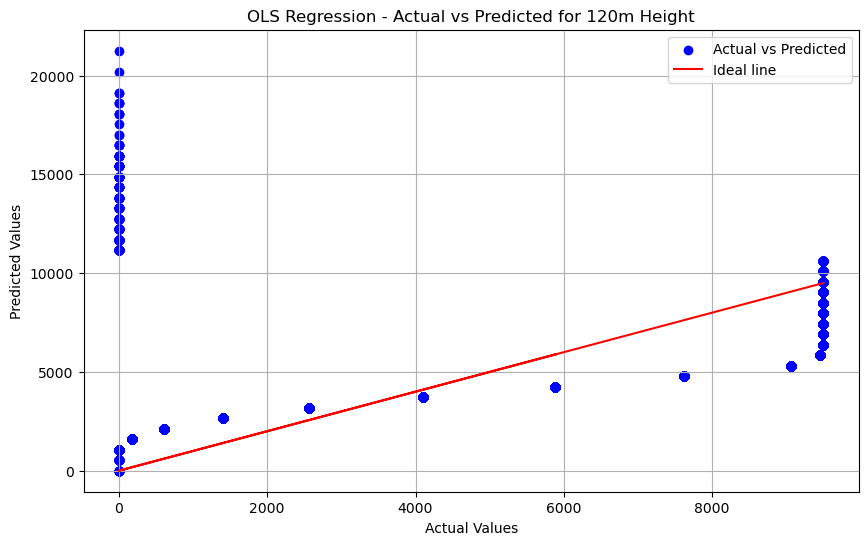

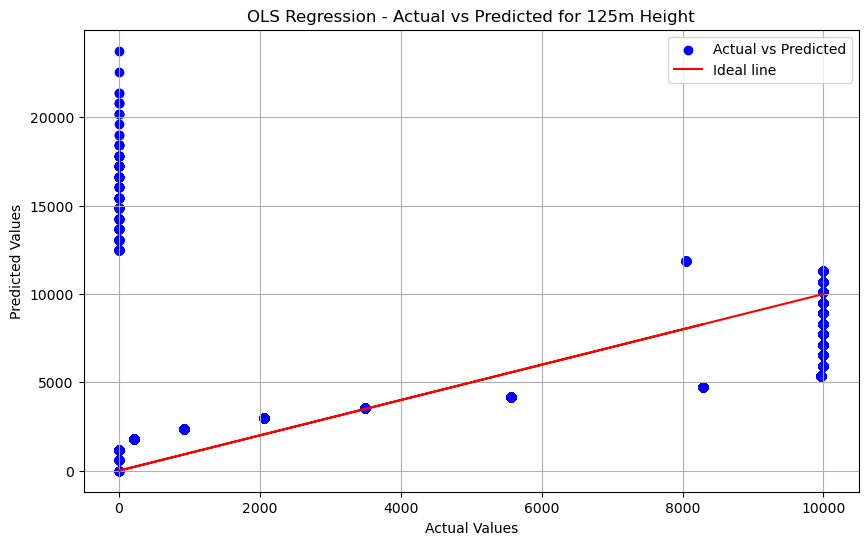

In [35]:
# Visualize predictions for 87m Height
plt.figure(figsize=(10, 6))
plt.scatter(y_test_87m, pred_87m, color='blue', label='Actual vs Predicted')
plt.plot(y_test_87m, y_test_87m, color='red', label='Ideal line')
plt.title('OLS Regression - Actual vs Predicted for 87m Height')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()
# Visualize predictions for 120m Height
plt.figure(figsize=(10, 6))
plt.scatter(y_test_120m, pred_120m, color='blue', label='Actual vs Predicted')
plt.plot(y_test_120m, y_test_120m, color='red', label='Ideal line')
plt.title('OLS Regression - Actual vs Predicted for 120m Height')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()
# Visualize predictions for 125m Height
plt.figure(figsize=(10, 6))
plt.scatter(y_test_125m, pred_125m, color='blue', label='Actual vs Predicted')
plt.plot(y_test_125m, y_test_125m, color='red', label='Ideal line')
plt.title('OLS Regression - Actual vs Predicted for 125m Height')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

In [36]:
# Initialize the Linear Regression model
model = RandomForestRegressor()
# Perform cross-validation for 87m Height
cv_scores_87m = cross_val_score(model, X, y_87m, cv=5, scoring='neg_mean_squared_error')
mse_mean_87m = -cv_scores_87m.mean()
# Perform cross-validation for 120m Height
cv_scores_120m = cross_val_score(model, X, y_120m, cv=5, scoring='neg_mean_squared_error')
mse_mean_120m = -cv_scores_120m.mean()
# Perform cross-validation for 125m Height
cv_scores_125m = cross_val_score(model, X, y_125m, cv=5, scoring='neg_mean_squared_error')
mse_mean_125m = -cv_scores_125m.mean()
print("Mean Squared Error (Cross-Validation) for 87m Height:", mse_mean_87m)
print("Mean Squared Error (Cross-Validation) for 120m Height:", mse_mean_120m)
print("Mean Squared Error (Cross-Validation) for 125m Height:", mse_mean_125m)


Mean Squared Error (Cross-Validation) for 87m Height: 1.6431671407741217e-21
Mean Squared Error (Cross-Validation) for 120m Height: 3.1253316884036147e-21
Mean Squared Error (Cross-Validation) for 125m Height: 5.478049654728008e-21
